<a href="https://colab.research.google.com/github/Jenarth/SCS3250-Group-2-Final-Project/blob/master/3_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **PHASE 3: MACHINE LEARNING**
---

#Classification with knn

K Nearest Neighbour is a simple algorithm that stores all the available cases and classifies a data point based on how its neighbours are classified.

We have a labelled dataset consisting of training observations (x,y)
and would like to capture the relationship between x and y. More formally, our goal is to learn a function F :X→Y so that given an unknown data observation x, F(x) can confidently predict the corresponding output y.

For our dataset, we have a number of attributes for one day - temperature, precipitation, weekday and month - which we can use to predict what the ridership would be on the given day. We will use the majority of the dataset to train the data and build the model, and then use a smaller test array to test out the model and check its accuracy.

We will use x to denote a feature (i.e. attribute) and y
to denote the target (i.e. class) we are trying to predict.

## Import Libraries

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import holidays
import matplotlib.pyplot as plt

##Read Final Dataset

In [182]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv')
dataset.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


##Prepare Dataset for Classification

For classification, we will focus our analysis on one station - Union. We will be selecting specific columns to use as attributes to predict the category in which our test data will fall.

###Removing outliers and holidays

The first step is to remove all outliers and holidays from the dataset to have uniform data

In [183]:
#only keep values without outliers/holidays
dataset  = dataset.loc[(-dataset.Holiday)&(-dataset.Outlier)]
dataset.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [184]:
dataset["Union Station Ridership"].max()

116029

In [185]:
dataset["Union Station Ridership"].min()

5736

###Creating bins for Union Ridership

We will be using the Union Rdiership as our target class to predict. For efficient classification, the Union ridership will be split into 16 ranges of equal sized bins (10,000 bin size) ranging from min of 0 to max of 160,000

In [186]:
#create bins for union ridership
ridership_bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000]
ridership_labels = ['0 to 10000','10000 to 20000','20000 to 30000','30000 to 40000','40000 to 50000','50000 to 60000','60000 to 70000','70000 to 80000','80000 to 90000','90000 to 100000','100000 to 110000','110000 to 120000','120000 to 130000','130000 to 140000','140000 to 150000','150000 to 160000']
dataset['Union Station Ridership Ranges'] = pd.cut(dataset['Union Station Ridership'], bins=ridership_bins, labels=ridership_labels)
dataset.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below,Union Station Ridership Ranges
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451,90000 to 100000
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508,90000 to 100000
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490,80000 to 90000
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198,10000 to 20000
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488,0 to 10000


In [187]:
dataset['Union Station Ridership Ranges'].unique()

[90000 to 100000, 80000 to 90000, 10000 to 20000, 0 to 10000, 70000 to 80000, 100000 to 110000, 20000 to 30000, 110000 to 120000]
Categories (8, object): [0 to 10000 < 10000 to 20000 < 20000 to 30000 < 70000 to 80000 <
                         80000 to 90000 < 90000 to 100000 < 100000 to 110000 < 110000 to 120000]

Text(0, 0.5, 'Frequency')

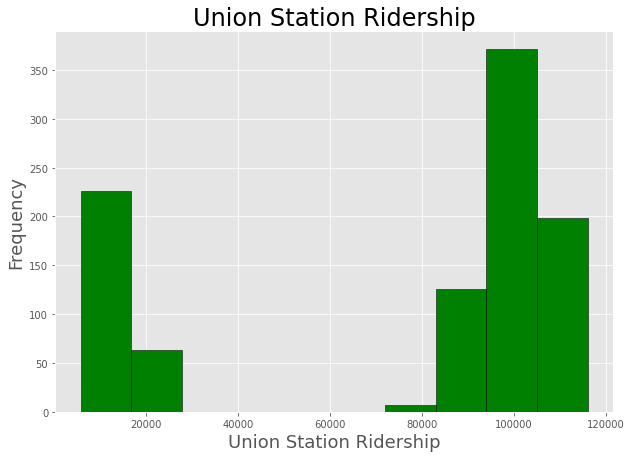

In [188]:
#plot to see distribution of Union ridership
plt.style.use('ggplot')

dataset["Union Station Ridership"].plot(kind='hist', color='green', edgecolor='black', figsize=(10,7))
plt.title('Union Station Ridership', size=24)
plt.xlabel('Union Station Ridership', size=18)
plt.ylabel('Frequency', size=18)

###Distribution of Delta Temperature

Text(0, 0.5, 'Frequency')

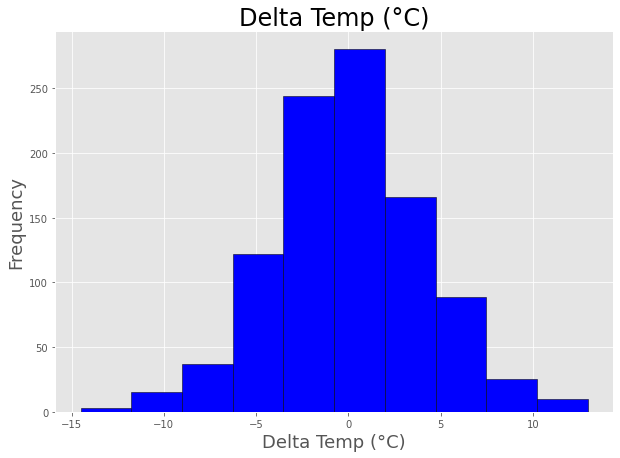

In [189]:
dataset["Delta Temp (°C)"].plot(kind='hist', color='blue', edgecolor='black', figsize=(10,7))
plt.title('Delta Temp (°C)', size=24)
plt.xlabel('Delta Temp (°C)', size=18)
plt.ylabel('Frequency', size=18)

###Distribution of Delta Precipitation

Text(0, 0.5, 'Frequency')

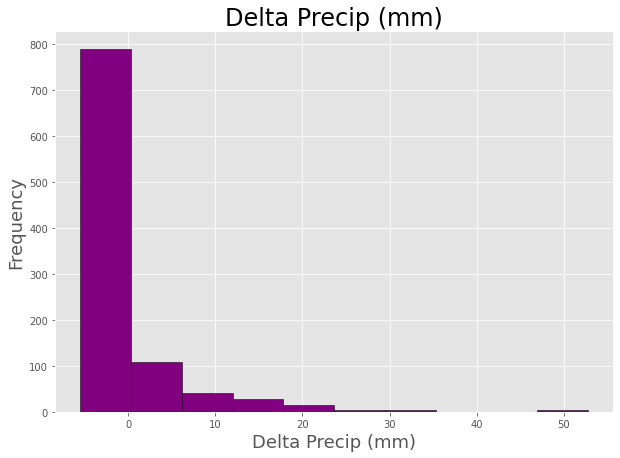

In [190]:
dataset["Delta Precip (mm)"].plot(kind='hist', color='purple', edgecolor='black', figsize=(10,7))
plt.title('Delta Precip (mm)', size=24)
plt.xlabel('Delta Precip (mm)', size=18)
plt.ylabel('Frequency', size=18)

###Preparing the weekday column for knn

Since knn only takes floats as attributes, the weekdays will be changed to a numeric value in numerical order, i.e. Sunday = 1, Monday = 2, Tuesday = 3, and so on.

In [191]:
#change weekdays to numbers

def CategorizeByWeekday(x):
    if x['Weekday']=='Sunday':
      val = 1
    elif x['Weekday']=='Monday':
      val = 2
    elif x['Weekday']=='Tuesday':
      val = 3
    elif x['Weekday']=='Wednesday':
      val = 4
    elif x['Weekday']=='Thursday':
      val = 5
    elif x['Weekday']=='Friday':
      val = 6
    elif x['Weekday']=='Saturday':
      val = 7            
    else:
      val = "None"
    return val

dataset["Weekday"] = dataset.apply(CategorizeByWeekday, axis = 1)

dataset

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below,Union Station Ridership Ranges
0,2017-03-01,2017,3,2017-03,1,4,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451,90000 to 100000
1,2017-03-02,2017,3,2017-03,2,5,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508,90000 to 100000
2,2017-03-03,2017,3,2017-03,3,6,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490,80000 to 90000
3,2017-03-04,2017,3,2017-03,4,7,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198,10000 to 20000
4,2017-03-05,2017,3,2017-03,5,1,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488,0 to 10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-02-25,2020,2,2020-02,25,3,False,5.6,1.7,3.7,-1.906897,5.606897,0.2,2.137931,-1.937931,0.0,13650,15097,29727,36973,17192,6865,10485,99431,229420,False,226142.086667,260553.155725,191731.017608,90000 to 100000
1092,2020-02-26,2020,2,2020-02,26,4,False,4.1,-3.2,0.4,-1.906897,2.306897,11.8,2.137931,9.662069,0.0,12596,13557,26690,33732,14331,6215,9749,98193,215063,False,227296.503311,254365.810172,200227.196451,90000 to 100000
1093,2020-02-27,2020,2,2020-02,27,5,False,-2.7,-5.3,-4.0,-1.906897,-2.093103,3.1,2.137931,0.962069,0.0,11349,13074,26818,34180,15281,5522,9151,94998,210373,False,224966.615894,253295.696280,196637.535508,90000 to 100000
1094,2020-02-28,2020,2,2020-02,28,6,False,-2.5,-9.4,-5.9,-1.906897,-3.993103,1.1,2.137931,-1.037931,0.0,11098,13008,27785,34263,14426,5629,8759,95108,210076,False,204211.905405,232457.905320,175965.905490,90000 to 100000


###Creation of master dataset for knn

To create a master dataset for knn classification, a copy of the original dataset was created ONLY with the relevant columns for attributes and category.

Attribute columns:
1. Month
2. Weekday
3. Delta Temp
4. Delta Precipitation

Category column:
1. Union Station Ridership Range

In [192]:
#create dataset for knn
knn_dataset = dataset[["Date","Month","Weekday","Delta Temp (°C)","Delta Precip (mm)","Union Station Ridership Ranges"]].copy()
knn_dataset

,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm),Union Station Ridership Ranges
0,2017-03-01,3,4,5.851613,16.064516,90000 to 100000
1,2017-03-02,3,5,-3.648387,-2.135484,90000 to 100000
2,2017-03-03,3,6,-5.948387,-2.335484,80000 to 90000
3,2017-03-04,3,7,-8.948387,-2.135484,10000 to 20000
4,2017-03-05,3,1,-5.248387,-2.335484,0 to 10000
...,...,...,...,...,...,...
1091,2020-02-25,2,3,5.606897,-1.937931,90000 to 100000
1092,2020-02-26,2,4,2.306897,9.662069,90000 to 100000
1093,2020-02-27,2,5,-2.093103,0.962069,90000 to 100000
1094,2020-02-28,2,6,-3.993103,-1.037931,90000 to 100000


In [193]:
#convert ridership to category
knn_dataset["Union Station Ridership Ranges"] = knn_dataset["Union Station Ridership Ranges"].astype('category')
knn_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 0 to 1095
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Date                            991 non-null    object  
 1   Month                           991 non-null    int64   
 2   Weekday                         991 non-null    int64   
 3   Delta Temp (°C)                 991 non-null    float64 
 4   Delta Precip (mm)               991 non-null    float64 
 5   Union Station Ridership Ranges  991 non-null    category
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 48.2+ KB


## knn predict for June 2019

In [194]:
X = knn_dataset[["Date","Month","Weekday","Delta Temp (°C)","Delta Precip (mm)"]]
X.head()

,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm)
0,2017-03-01,3,4,5.851613,16.064516
1,2017-03-02,3,5,-3.648387,-2.135484
2,2017-03-03,3,6,-5.948387,-2.335484
3,2017-03-04,3,7,-8.948387,-2.135484
4,2017-03-05,3,1,-5.248387,-2.335484


###Convert attribute columns to floats

In [195]:
cols = ['Month', 'Weekday', 'Delta Temp (°C)', 'Delta Precip (mm)']
for col in cols:
   X[col] = X[col].apply(lambda x: float(x) if x == x else "")
X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm)
0,2017-03-01,3.0,4.0,5.851613,16.064516
1,2017-03-02,3.0,5.0,-3.648387,-2.135484
2,2017-03-03,3.0,6.0,-5.948387,-2.335484
3,2017-03-04,3.0,7.0,-8.948387,-2.135484
4,2017-03-05,3.0,1.0,-5.248387,-2.335484
...,...,...,...,...,...
1091,2020-02-25,2.0,3.0,5.606897,-1.937931
1092,2020-02-26,2.0,4.0,2.306897,9.662069
1093,2020-02-27,2.0,5.0,-2.093103,0.962069
1094,2020-02-28,2.0,6.0,-3.993103,-1.037931


In [196]:
y = knn_dataset["Union Station Ridership Ranges"]
y.head()

0    90000 to 100000
1    90000 to 100000
2     80000 to 90000
3     10000 to 20000
4         0 to 10000
Name: Union Station Ridership Ranges, dtype: category
Categories (16, object): [0 to 10000 < 10000 to 20000 < 20000 to 30000 < 30000 to 40000 < ... <
                          120000 to 130000 < 130000 to 140000 < 140000 to 150000 < 150000 to 160000]

###Separating the data manually to use June 2019 as testing set and the rest for training set

In [197]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#use June 2019 as test data

X_train_1 = X.loc[(X['Date']>"2017-03-01") & (X['Date']<"2019-06-01")]
X_train_2 = X.loc[(X['Date']>"2019-06-30") & (X['Date']<"2020-03-01")]
X_train = pd.concat([X_train_1, X_train_2], ignore_index=True, sort =False)
X_train.drop('Date', axis=1, inplace=True)
X_train

,Month,Weekday,Delta Temp (°C),Delta Precip (mm)
0,3.0,5.0,-3.648387,-2.135484
1,3.0,6.0,-5.948387,-2.335484
2,3.0,7.0,-8.948387,-2.135484
3,3.0,1.0,-5.248387,-2.335484
4,3.0,2.0,-9.548387,-2.335484
...,...,...,...,...
956,2.0,3.0,5.606897,-1.937931
957,2.0,4.0,2.306897,9.662069
958,2.0,5.0,-2.093103,0.962069
959,2.0,6.0,-3.993103,-1.037931


In [198]:
X_test = X.loc[(X['Date']>"2019-05-31") & (X['Date']<"2019-07-01")]
X_test.drop('Date', axis=1, inplace=True)
X_test.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(29, 4)

In [199]:
y_train_1 = y.loc[(X['Date']>"2017-03-01") & (X['Date']<"2019-06-01")]
y_train_2 = y.loc[(X['Date']>"2019-06-30") & (X['Date']<"2020-03-01")]
y_train = pd.concat([y_train_1, y_train_2], ignore_index=True, sort =False)
y_train.shape

(961,)

In [200]:
y_test = y.loc[(X['Date']>"2019-05-31") & (X['Date']<"2019-07-01")]
y_test.shape

(29,)

###Initial knn predict run with 5 neighbours

In [201]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_hat = knn.predict(X_test)
y_hat

array(['10000 to 20000', '10000 to 20000', '100000 to 110000',
       '100000 to 110000', '90000 to 100000', '90000 to 100000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '90000 to 100000', '100000 to 110000', '90000 to 100000',
       '90000 to 100000', '90000 to 100000', '10000 to 20000',
       '10000 to 20000', '100000 to 110000', '100000 to 110000',
       '100000 to 110000', '80000 to 90000', '10000 to 20000',
       '0 to 10000', '100000 to 110000', '100000 to 110000',
       '100000 to 110000', '90000 to 100000', '100000 to 110000',
       '10000 to 20000', '10000 to 20000'], dtype=object)

In [202]:
y_test

822      10000 to 20000
823      10000 to 20000
824    100000 to 110000
825    100000 to 110000
826    100000 to 110000
827    100000 to 110000
828     90000 to 100000
829      10000 to 20000
830      10000 to 20000
831    100000 to 110000
832    100000 to 110000
833    100000 to 110000
834    100000 to 110000
835     90000 to 100000
836      10000 to 20000
837      10000 to 20000
839    100000 to 110000
840    100000 to 110000
841    100000 to 110000
842     90000 to 100000
843      10000 to 20000
844      10000 to 20000
845    100000 to 110000
846    100000 to 110000
847    100000 to 110000
848    100000 to 110000
849      80000 to 90000
850      10000 to 20000
851      10000 to 20000
Name: Union Station Ridership Ranges, dtype: category
Categories (16, object): [0 to 10000 < 10000 to 20000 < 20000 to 30000 < 30000 to 40000 < ... <
                          120000 to 130000 < 130000 to 140000 < 140000 to 150000 < 150000 to 160000]

In [203]:
accuracy_score(y_test,y_hat)

0.6551724137931034

###Identify optimal number of neighbours

In order to identify the optimal number of neighbours for this model, we ran knn with a range if neighbours (1 to 100) and plotted the number of neighbours against the accuracy score.

In [0]:
neighbors = range(1,100)
error = []
score = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    score.append(accuracy_score(y_test, y_hat))

Text(0, 0.5, 'Accuracy Score')

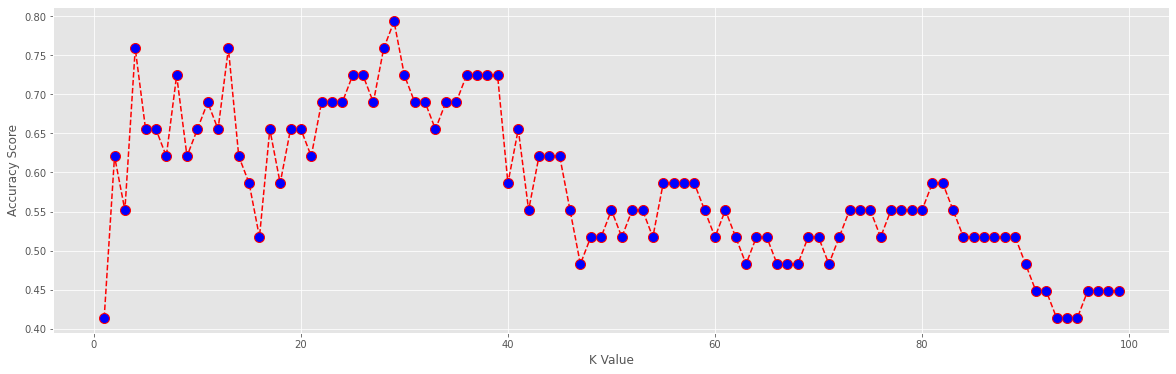

In [205]:
plt.figure(figsize=(20, 6))
plt.plot(neighbors, score, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel('K Value')
plt.ylabel('Accuracy Score')

The optimal number of neighbors was 29 based on the plot, which gave an accuracy score of 79.3%.

In [206]:
knn = KNeighborsClassifier(n_neighbors=29) #best score
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
score = accuracy_score(y_test, y_hat)
score

0.7931034482758621

###Using the model to predict the ridership for a random day in our dataset

In order to test the model, we will apply this model to predict the ridership on a random day in the dataset. We extracted one row from our dataset to use as X_train - 5th April, 2019. The actual ridership bin for the day has also been extracted to see if our prediction matches the actual.

In [0]:
X = X.loc[X["Date"]=="2019-04-05"]

In [208]:
X.drop('Date', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [209]:
y = knn_dataset.loc[knn_dataset["Date"]=="2019-04-05"]
y

,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm),Union Station Ridership Ranges
765,2019-04-05,4,6,-4.276667,-3.946667,90000 to 100000


In [210]:
y_test = knn.predict(X)
y_test

array(['90000 to 100000'], dtype=object)

It looks like our predicted value for ridership (y_test = [90000 to 100000]) matches the actual value (y).

## knn predict for Mondays

A similar exercise was done for all Mondays in the dataset. We built a knn model to predict the ridership only for Mondays, given the same attributes and target class. 

In [211]:
knn_dataset = dataset[["Date","Month","Weekday","Delta Temp (°C)","Delta Precip (mm)","Union Station Ridership Ranges"]].copy()
knn_dataset.head()

,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm),Union Station Ridership Ranges
0,2017-03-01,3,4,5.851613,16.064516,90000 to 100000
1,2017-03-02,3,5,-3.648387,-2.135484,90000 to 100000
2,2017-03-03,3,6,-5.948387,-2.335484,80000 to 90000
3,2017-03-04,3,7,-8.948387,-2.135484,10000 to 20000
4,2017-03-05,3,1,-5.248387,-2.335484,0 to 10000


In [212]:
knn_dataset_M = knn_dataset.loc[knn_dataset["Weekday"]==1]
knn_dataset_M.head()

,Date,Month,Weekday,Delta Temp (°C),Delta Precip (mm),Union Station Ridership Ranges
4,2017-03-05,3,1,-5.248387,-2.335484,0 to 10000
11,2017-03-12,3,1,-7.948387,-2.335484,0 to 10000
18,2017-03-19,3,1,3.651613,-2.335484,10000 to 20000
25,2017-03-26,3,1,4.151613,0.064516,0 to 10000
32,2017-04-02,4,1,0.963333,-3.586667,0 to 10000


In [213]:
knn_dataset_M["Union Station Ridership Ranges"] = knn_dataset_M["Union Station Ridership Ranges"].astype('category')
knn_dataset_M.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 4 to 1089
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Date                            143 non-null    object  
 1   Month                           143 non-null    int64   
 2   Weekday                         143 non-null    int64   
 3   Delta Temp (°C)                 143 non-null    float64 
 4   Delta Precip (mm)               143 non-null    float64 
 5   Union Station Ridership Ranges  143 non-null    category
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 7.6+ KB


In [214]:
X = knn_dataset_M[["Month","Weekday","Delta Temp (°C)","Delta Precip (mm)"]]
X.shape

(143, 4)

In [215]:
cols = ['Month', 'Weekday', 'Delta Temp (°C)', 'Delta Precip (mm)']
for col in cols:
   X[col] = X[col].apply(lambda x: float(x) if x == x else "")
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 4 to 1089
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              143 non-null    float64
 1   Weekday            143 non-null    float64
 2   Delta Temp (°C)    143 non-null    float64
 3   Delta Precip (mm)  143 non-null    float64
dtypes: float64(4)
memory usage: 5.6 KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [216]:
y = knn_dataset_M["Union Station Ridership Ranges"]
y.shape

(143,)

In [217]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=20)
X_train.shape

(114, 4)

In [218]:
knn.fit(X_train,y_train)
y_hat = knn.predict(X_test)
y_hat

array(['10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000'], dtype=object)

In [219]:
y_test

501     10000 to 20000
361         0 to 10000
851     10000 to 20000
494     10000 to 20000
746     10000 to 20000
592         0 to 10000
417         0 to 10000
270         0 to 10000
998     10000 to 20000
977         0 to 10000
676         0 to 10000
662     10000 to 20000
221     10000 to 20000
368         0 to 10000
424     10000 to 20000
529     10000 to 20000
263     10000 to 20000
627     10000 to 20000
144         0 to 10000
4           0 to 10000
284         0 to 10000
81          0 to 10000
515     10000 to 20000
795         0 to 10000
396     10000 to 20000
711         0 to 10000
11          0 to 10000
1047        0 to 10000
942     10000 to 20000
Name: Union Station Ridership Ranges, dtype: category
Categories (16, object): [0 to 10000 < 10000 to 20000 < 20000 to 30000 < 30000 to 40000 < ... <
                          120000 to 130000 < 130000 to 140000 < 140000 to 150000 < 150000 to 160000]

In [220]:
accuracy_score(y_test,y_hat)

0.4827586206896552

In [221]:
neighbors = range(1,60)
error = []
score = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    score.append(accuracy_score(y_test, y_hat))
y_hat

array(['10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000', '10000 to 20000',
       '10000 to 20000', '10000 to 20000'], dtype=object)

Text(0, 0.5, 'Accuracy Score')

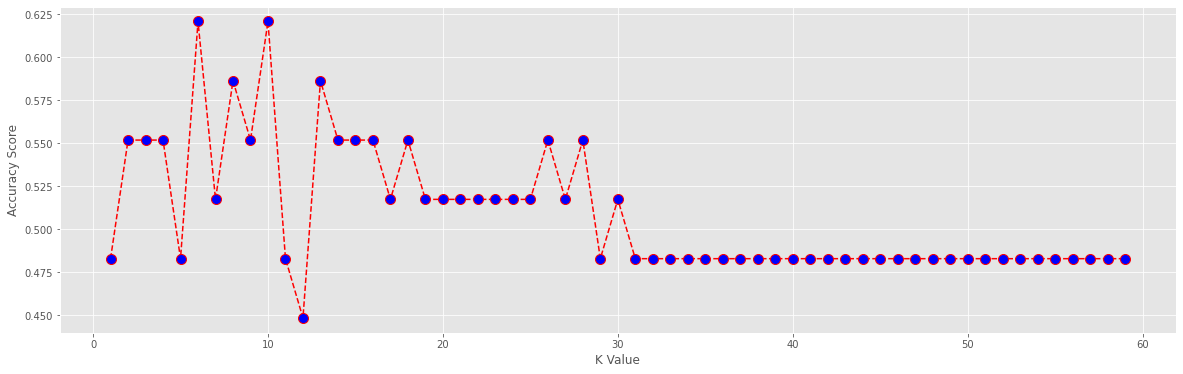

In [222]:
plt.figure(figsize=(20, 6))
plt.plot(neighbors, score, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel('K Value')
plt.ylabel('Accuracy Score')

The optimal number of neighbors was 6 based on the plot, which gave an accuracy score of 62%.

In [223]:
knn = KNeighborsClassifier(n_neighbors=6) #best score
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
score = accuracy_score(y_test, y_hat)
score

0.6206896551724138

# Linear Regression

## Linear Regression with Weekdays - Part 1

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
%matplotlib inline

In [0]:
# Let's import the dataset

url = 'https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv'
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [226]:
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [227]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [228]:
# Let's create a new dataset to only select the month of January

jan_df = df[(df.Month == 1)& (df.Year != 2017)]
jan_df.head(2)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
306,2018-01-01,2018,1,2018-01,1,1,True,-7.9,-18.6,-13.3,-4.383871,-8.916129,0.2,1.929032,-1.729032,0.0,857,366,3844,6347,96,0,131,8728,20369,True,NaN,NaN,NaN
307,2018-01-02,2018,1,2018-01,2,2,False,-7.1,-12.5,-9.8,-4.383871,-5.416129,0.0,1.929032,-1.929032,0.0,7706,10584,20084,25182,12040,4359,6969,74432,161356,True,NaN,NaN,NaN


Let's plot our data points on a graph to eyeball our dataset. We will take a look specifically at Union Station, a central station in Toronto.

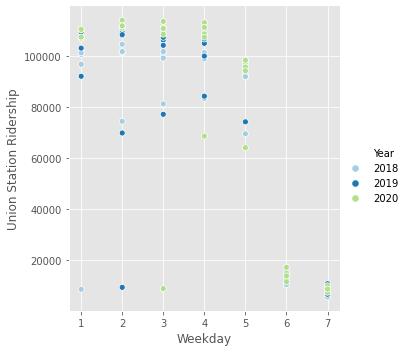

In [229]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=jan_df,hue='Year',palette='Paired')

We notice one outliner by year where there is very little Riderships: the 1st of January.

Let's check our average Riderships for Union Station.

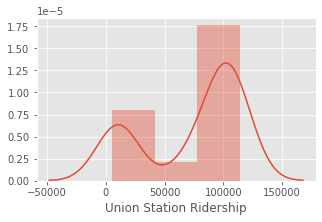

In [230]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(jan_df['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=jan_df['Weekday'].values.reshape(-1,1)
y=jan_df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [233]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [234]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[133086.70290928]
[[-15336.91472794]]


In [0]:
y_pred = regressor.predict(X_test)

In [236]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,81222,87076.0
1,104331,87076.0
2,96768,56402.0
3,101709,87076.0
4,9598,25728.0
5,92037,117750.0
6,99938,71739.0
7,109227,102413.0
8,84255,71739.0
9,112993,71739.0


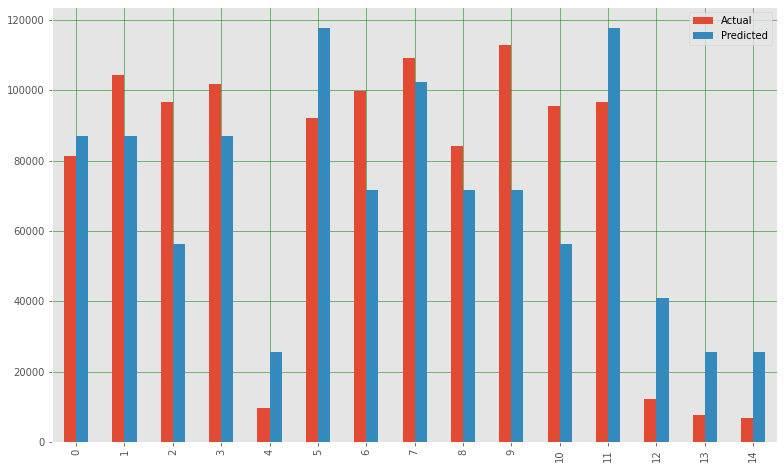

In [237]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Linear Regression with Weekdays - Part 2

In [0]:
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [239]:
# Let's remove the outliers as well as the holidays period

data= df.loc[(-df.Holiday)&(-df.Outlier)]
data.head(5)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [240]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
data.Weekday = [weekday[item] for item in data.Weekday]
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


Let's plot our data points on a graph. Here again will take a look specifically at Union Station, a central station in Toronto.

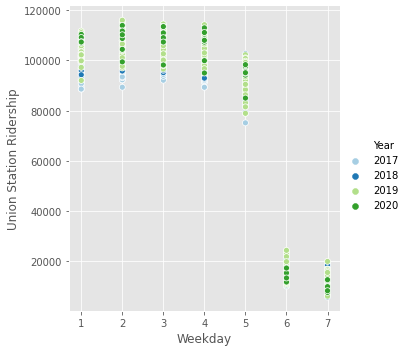

In [241]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=data,hue='Year',palette='Paired')

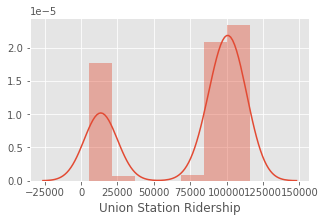

In [242]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(data['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=data['Weekday'].values.reshape(-1,1)
y=data['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [245]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [246]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[141774.68776727]
[[-16544.87902787]]


In [0]:
y_pred = regressor.predict(X_test)

In [248]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,107492,108685.0
1,100565,75595.0
2,96529,108685.0
3,95809,108685.0
4,108883,108685.0
...,...,...
194,98263,75595.0
195,98114,108685.0
196,98723,59050.0
197,101471,75595.0


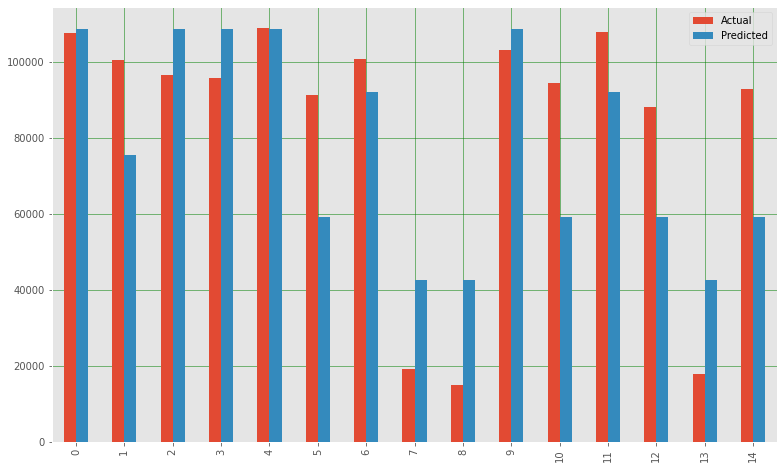

In [249]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Our initial thought was that by removing the outliers and expanding the data frame to cover the whole year would lead to a more precise predictive model.
After running the analysis, the model studied in part 2 seems more accurate.

## Multiple Linear Regression with 2 Variables

In [0]:
df = pd.read_csv(url,index_col='Date', parse_dates=True)

In [251]:
# Let's convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [0]:
# Build linear regression model using Weekday and Precipitation as predictors
# Split data into predictors X and output Y

predictors = ['Weekday','Total Precip (mm)']
X= df[predictors]
y=df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)

Instead of calulcating the values for alpha and betas, we have to call .intercept for alpha, and .coef_ for an array with our coefficients.



In [254]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [130407.35411283]
betas = [[-14521.08711066   -117.60454459]]


We can predict the values by using .predict()

In [255]:
y_pred = model.predict(X)
y_pred

array([[84680.16916041],
       [72299.48476126],
       [57801.91855952],
       ...,
       [71958.43158196],
       [57672.55356047],
       [43139.70599535]])

In [256]:
new_X = [[7, 0.2]]
print(model.predict(new_X))

[[28736.22342928]]


Now that we have our predicting model, let's randomly pick a day and assess how far (or close) our model is from reality.

In [257]:
df[['Weekday','Total Precip (mm)','Union Station Ridership']].tail(15)

,Weekday,Total Precip (mm),Union Station Ridership
Date,,,
2020-02-15,6,0.4,15296
2020-02-16,7,0.4,12262
2020-02-17,1,1.0,11370
2020-02-18,2,8.6,104432
2020-02-19,3,0.0,107351
2020-02-20,4,1.0,108033
2020-02-21,5,0.2,94914
2020-02-22,6,0.2,17267
2020-02-23,7,0.8,12615


In [258]:
# Let's look at the 18th of February
prediction_1 = [[2, 8.6]]
print(model.predict(prediction_1))

[[100353.78080804]]


The model predicted 742,228 riderships while the actual number was 773,600: the prediction was pretty close.

In [259]:
# Let's look at the 26th of February 2020
prediction_2 = [[3, 11.8]]
print(model.predict(prediction_2))

[[85456.35915469]]


The model predicted 631,344 riderships while the actual number was 727,372. The prediction here was not as accurate.

## Linear Regression for Weekend Ridership Predicted by Temperature

In [260]:
# Importing the dataset and setting the date as index
data = pd.read_csv('https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,2020,2,2020-02,25,Tuesday,False,5.6,1.7,3.7,-1.906897,5.606897,0.2,2.137931,-1.937931,0.0,13650,15097,29727,36973,17192,6865,10485,99431,229420,False,226142.086667,260553.155725,191731.017608
2020-02-26,2020,2,2020-02,26,Wednesday,False,4.1,-3.2,0.4,-1.906897,2.306897,11.8,2.137931,9.662069,0.0,12596,13557,26690,33732,14331,6215,9749,98193,215063,False,227296.503311,254365.810172,200227.196451
2020-02-27,2020,2,2020-02,27,Thursday,False,-2.7,-5.3,-4.0,-1.906897,-2.093103,3.1,2.137931,0.962069,0.0,11349,13074,26818,34180,15281,5522,9151,94998,210373,False,224966.615894,253295.696280,196637.535508


**Looking at weekday ridership**

By analyzing the data, it is clear that ridership varies depending on whether the day is a weekday or weekend. First, the weekday data will be looked at. The weekday data is split from the main dataset here.



In [261]:
# Splitting data by day and concating the weekdays together
monday_data = data.loc[data['Weekday'] == 'Monday']
tuesday_data = data.loc[data['Weekday'] == 'Tuesday']
wednesday_data = data.loc[data['Weekday'] == 'Wednesday']
thursday_data = data.loc[data['Weekday'] == 'Thursday']
friday_data = data.loc[data['Weekday'] == 'Friday']
weekday_data= pd.concat([monday_data, tuesday_data, wednesday_data, thursday_data, friday_data])
weekday_data = weekday_data.sort_values(by='Date' ,ascending=True)
weekday_data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-06,2017,3,2017-03,6,Monday,False,4.9,-0.9,-9.8,-0.251613,-9.548387,0.0,2.335484,-2.335484,0.0,10154,13622,24393,31993,15964,5787,8740,94530,205183,False,219741.340909,261398.518741,178084.163077
2017-03-07,2017,3,2017-03,7,Tuesday,False,10.9,6.4,8.7,-0.251613,8.951613,9.6,2.335484,7.264516,0.0,10200,13754,25540,33525,16051,5738,8777,95390,208975,False,226142.086667,260553.155725,191731.017608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,2020,2,2020-02,24,Monday,False,9.4,2.2,5.8,-1.906897,7.706897,1.1,2.137931,-1.037931,0.0,13376,15108,29214,36460,17446,6869,10305,107350,236128,False,219741.340909,261398.518741,178084.163077
2020-02-25,2020,2,2020-02,25,Tuesday,False,5.6,1.7,3.7,-1.906897,5.606897,0.2,2.137931,-1.937931,0.0,13650,15097,29727,36973,17192,6865,10485,99431,229420,False,226142.086667,260553.155725,191731.017608
2020-02-26,2020,2,2020-02,26,Wednesday,False,4.1,-3.2,0.4,-1.906897,2.306897,11.8,2.137931,9.662069,0.0,12596,13557,26690,33732,14331,6215,9749,98193,215063,False,227296.503311,254365.810172,200227.196451


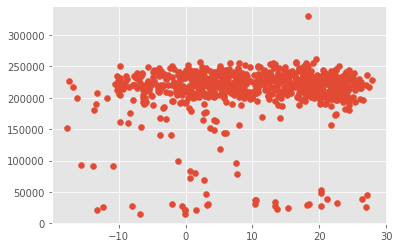

In [262]:
# Plotting weekday mean temperature with GO ridership
plt.scatter(weekday_data['Mean Temp (°C)'], weekday_data['Total GO Ridership'])

By looking at the weekday data above, there is no clear correlation between Weekday ridership (across all GO lines) and weekday temperature. Due to this, it doesn't make much sense to create a machine learning model to predict ridership on weekdays using temperature.

**Looking at weekend ridership**

First the weekend data needs to be split from the dataset.



In [263]:
# Splitting data by day and concating the weekend days together
saturday_data = data.loc[data['Weekday'] == 'Saturday']
sunday_data = data.loc[data['Weekday'] == 'Sunday']
weekend_data= pd.concat([saturday_data, sunday_data])
weekend_data = weekend_data.sort_values(by='Date' ,ascending=True)
weekend_data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488
2017-03-11,2017,3,2017-03,11,Saturday,False,-5.3,-12.5,-8.9,-0.251613,-8.648387,0.2,2.335484,-2.135484,0.5,877,463,6397,11193,174,0,199,10584,29887,False,45352.333333,73886.656469,16818.010198
2017-03-12,2017,3,2017-03,12,Sunday,False,-3.8,-12.5,-8.2,-0.251613,-7.948387,0.0,2.335484,-2.335484,0.5,756,345,4031,6915,97,2,102,6721,18969,False,32455.370861,53039.519234,11871.222488
2017-03-18,2017,3,2017-03,18,Saturday,False,3.1,0.1,1.6,-0.251613,1.851613,1.5,2.335484,-0.835484,0.0,1187,632,8199,13669,210,0,276,15697,39870,False,45352.333333,73886.656469,16818.010198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-15,2020,2,2020-02,15,Saturday,False,1.1,-8.7,-3.8,-1.906897,-1.893103,0.4,2.137931,-1.737931,0.0,1535,259,8070,11895,98,0,1014,15296,38167,False,45352.333333,73886.656469,16818.010198
2020-02-16,2020,2,2020-02,16,Sunday,False,4.3,-1.5,1.4,-1.906897,3.306897,0.4,2.137931,-1.737931,0.0,1501,169,6133,9534,73,0,795,12262,30467,False,32455.370861,53039.519234,11871.222488
2020-02-22,2020,2,2020-02,22,Saturday,False,5.5,-3.2,1.1,-1.906897,3.006897,0.2,2.137931,-1.937931,0.0,2323,271,9654,15429,121,0,1181,17267,46246,False,45352.333333,73886.656469,16818.010198


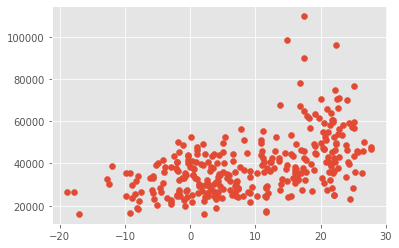

In [264]:
# Plotting weekday mean temperature with GO ridership
plt.scatter(weekend_data['Mean Temp (°C)'], weekend_data['Total GO Ridership'])

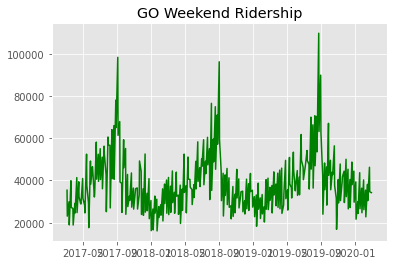

In [265]:
# Plotting Total GO Ridership on weekends over 3 years
plt.plot(weekend_data.index, weekend_data['Total GO Ridership'], color='green')
plt.title('GO Weekend Ridership')
plt.show()

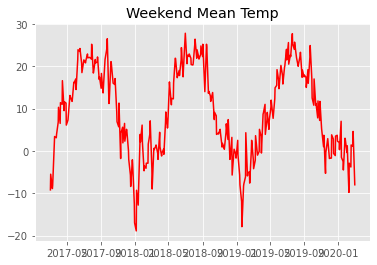

In [266]:
# Plotting mean temperature on weekends over 3 years
plt.plot(weekend_data.index, weekend_data['Mean Temp (°C)'], color='red')
plt.title('Weekend Mean Temp')
plt.show()

Here it is clear that there is a positive correlation between the weekend temperature and GO ridership (across all GO lines). It makes sense to attempt to build a machine learning model to predict the GO ridership (across all lines) for a given temperature.

**Building a Linear Regression Model for Weekend GO Ridership**

For the linear regression model, Total GO Ridership and Mean Temperature will be used.



In [267]:
#Using linear regression to fit a model and printing the coefficient and intercept
Y = weekend_data['Total GO Ridership']
X = weekend_data['Mean Temp (°C)'].values.reshape(-1, 1)

weekend_model = sklearn.linear_model.LinearRegression().fit(X,Y)
print(weekend_model.coef_)
print(weekend_model.intercept_)

[671.86679794]
32640.777367924864


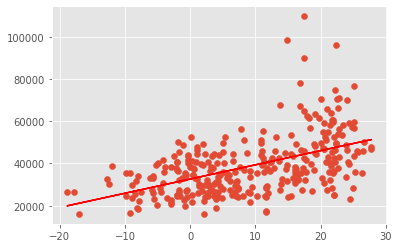

In [268]:
# Plotting Mean Temp (°C), Total GO Ridership, and the model
weekend_predict = weekend_model.predict(X)
plt.scatter(x=weekend_data['Mean Temp (°C)'], y=weekend_data['Total GO Ridership'])
plt.plot(X, weekend_predict, 'r-')
plt.show()

Above, the red line represents the best fit produced by the model. The model can be used to predict the GO ridership (across all lines) for any given temperature.



In [269]:
print(weekend_model.predict([[-5],[5],[15],[25]]))

[29281.44337823 36000.11135762 42718.77933702 49437.44731641]


Predicting the GO ridership for a tempreature of -5°C gives us a ridership of 29281. Similiarly for: 5°C = 36000, 15°C = 42718, 25°C = 49437.

In [270]:
# Calculating Root Mean Square Error
mse = mean_squared_error(Y, weekend_predict)
rmse = np.sqrt(mse)
print(rmse)

12055.52441187086


The Root Mean Square Error(RMSE) here is 12055. The best fit should have the lowest possible value for RMSE. Looking at the data, 12055 is fairly low for a data that has range from 0 to 120000. This is a fairly good model!